In [1]:
# Код для prochack турнира

import os
os.getcwd() # "/Users/nikitabaramiya/"
#os.chdir("/Users/nikitabaramiya/Desktop/prohack_dataset")
os.chdir("C:\\Users\\msi\\Documents\\Sergey\\ML Sergey\\first hackathon")

In [2]:
from functools import reduce
from collections import Counter
# для анализа времени работы алгоритмов
import time
from datetime import datetime
# для обработки данных
import numpy as np
import pandas as pd
# для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

# для заполнения пропусков и стандартизации
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor # также используем в ансамбле
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# предсказательные модели
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
# ансамбли
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
# ускоренная версия градиентного бустинга
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor

# для построения и оценивания моделей
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

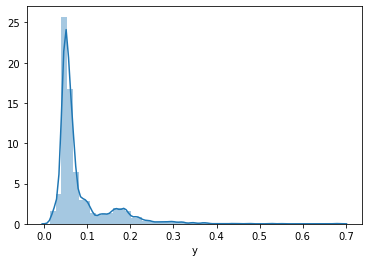

In [3]:
###############################################################################################################################################
# импортируем данные
df_train = pd.read_csv('train.csv')
df_train.shape # (3865, 80)
df_test = pd.read_csv('test.csv')
df_test.shape # (890, 79)
df_sample_submit = pd.read_csv('sample_submit.csv')
df_sample_submit.shape # (890, 3)


# смотрим уникальные звёзды в тренировке и тесте
galaxies_train = set(df_train.galaxy)
galaxies_test = set(df_test.galaxy)

galaxies_test - galaxies_train # set()
galaxies_train - galaxies_test # {'Andromeda XXIV', 'Andromeda XVIII[60]', 'Triangulum Galaxy (M33)',
# 'Andromeda XXII[57]', 'Tucana Dwarf', 'Andromeda XII', 'Andromeda XIX[60]', 'NGC 5253', 'Hercules Dwarf'}

galaxies_train_dict = Counter(df_train.galaxy)
galaxies_train_dict.most_common()

# в тренировке больше звёзд, это хорошо, попробуем использовать дамми звёзд
dummy_train = pd.get_dummies(df_train['galaxy'])
df_train = pd.concat([df_train, dummy_train], axis = 1)
df_train.drop(columns='galaxy', inplace=True)

dummy_test = pd.get_dummies(df_test['galaxy'])
df_test = pd.concat([df_test, dummy_test], axis = 1)
df_test.drop(columns='galaxy', inplace=True)

# уберём целевую переменную
y_train = df_train['y']
X_train = df_train.drop(columns = ['y'])
X_train.shape # (3865, 259)
df_test.shape # (890, 250)

# дозаполним отсутсвующими столбцами
X_test = df_test.copy()
for col in list(galaxies_train - galaxies_test):
    X_test[col] = 0

X_test.shape # (890, 259)

# посмотрим, какая у нас целевая переменная
y_train.describe()
sns.distplot(y_train)
plt.show()

In [ ]:
###############################################################################################################################################
# Проверка разных imputers -- сошлись на BayesianRidge

# good_imputer = IterativeImputer(random_state = 0, estimator = BayesianRidge())
# X_train_f = good_imputer.fit_transform(X_train)
# pd.DataFrame(X_train_f).to_csv("BayesianRidge_X_train.csv", index = False)

X_train_fill = pd.read_csv("BayesianRidge_X_train.csv")

# Дальше экспериментируем с параметрами для лучших алгоритмов

estimators = [
    ElasticNet(),
    AdaBoostRegressor(),
    RandomForestRegressor(),
    HistGradientBoostingRegressor(),
    XGBRegressor()
]

# лист гиперпараметров
tuned_parameters = [
    # {'normalize': [True], 'alpha': np.logspace(-10, 1, 50), 'l1_ratio': [0, .1, .5, .7, .9, .95, .99, 1], 'max_iter': [2000]}, # всегда нормируем !!!
    # {'alpha': 8.68511373751352e-06, 'l1_ratio': 0.1, 'max_iter': 2000, 'normalize': True} -- намёк на лишние переменные, а может и нет
    {'normalize': [True], 'alpha': [8.68511373751352e-06], 'l1_ratio': [0.1], 'max_iter': [2000]},
    # {'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'random_state': [0]},
    # {'n_estimators': 20, 'random_state': 0}
    {'n_estimators': [15, 20, 25], 'random_state': [0]},
    # {'n_estimators': [200, 300], 'random_state': [0], 'max_depth': [*range(18, 20)]},
    # всегда росло с 2 до 18 для n_estimators = 200, поэтому гляну дальше
    {'n_estimators': [250], 'random_state': [0], 'max_depth': range(18, 21, 1)},
    {'max_iter': [250], 'random_state': [0], 'max_depth': [11]},
    # были проверены все глубины меньше и больше, остановлюсь на 11
    {'n_estimators': [250], 'min_child_weight': range(1, 6, 2), 'gamma': [0.5, 1.0], 'subsample': [0.8, 1.0], \
    'colsample_bytree': [0.7, 1.0], 'random_state': [0], 'max_depth': range(3, 10, 2)}
    #
]

# пытаемся улучшить предсказание поиском лучших параметров (пока среди тех комбинаций и алгоритмов)
i = 0
all_info = [np.nan for i in range(len(estimators))]
grid_scores = [np.inf for i in range(len(estimators))]
best_params = [np.nan for i in range(len(estimators))]

for t, br_estimator in enumerate(estimators):
    time = datetime.now()
    print("Estimator: {}".format(br_estimator.__class__.__name__))
    clf = GridSearchCV(br_estimator, tuned_parameters[t])
    clf.fit(X_train_fill, y_train)
    all_info[i] = clf.cv_results_
    grid_scores[i] = clf.best_score_
    print(grid_scores[i])
    best_params[i] = clf.best_params_
    print(best_params[i])
    i += 1
    print("Time: {}".format(datetime.now() - time))
    print("----------------------------------------------------------")



###############################################################################################################################################
X_train_f = pd.read_csv("BayesianRidge_X_train.csv")

# вроде как лучшие
k_f = KFold(n_splits = 10, shuffle = True, random_state = 0)

# неожиданный и простой король -- эластичная сеть
algo_1 = ElasticNetCV(l1_ratio = 0.1, normalize = True, max_iter = 1500) # adaboost ломает его!
algo_1_score = cross_val_score(algo_1, X_train_f, y_train, scoring = 'r2', cv = k_f)
np.round(np.mean(algo_1_score), 3) # 0.942
# algo_1_score = cross_val_score(algo_1, X_train_f, y_train, scoring = 'neg_mean_squared_error', cv = k_f) среднеквадратическая ошибка -- 0.000243

# не неожиданный лес
algo_2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
algo_2_score = cross_val_score(algo_2, X_train_f, y_train, scoring = 'r2', cv = k_f)
np.round(np.mean(algo_2_score), 3) # 0.917

# также не неожиданный бустинг
algo_3 = HistGradientBoostingRegressor(max_depth = 11, max_iter = 500, random_state = 0)
algo_3_score = cross_val_score(algo_3, X_train_f, y_train, scoring = 'r2', cv = k_f)
np.round(np.mean(algo_3_score), 3) # 0.899 (раньше было 0.9, без фикс глубины, решил ограничить, мб позволит не переобучаться)


# попробуем их всех объединить
estims = [
    ('RF', RandomForestRegressor(n_estimators = 100, random_state = 0)),
    ('GB', HistGradientBoostingRegressor(max_depth = 11, max_iter = 500, random_state = 0))
]

# лес и бустинг генерирует даннные, на них обучаем эластичную сеть (эластичная сеть и бустинг генерирует даннные, на них обучаем лес -- плохо)
reg = StackingRegressor(estimators = estims, final_estimator = ElasticNetCV(l1_ratio = 0.1, normalize = True, max_iter = 1500), passthrough = True)
reg_score = cross_val_score(reg, X_train_f, y_train, scoring = 'r2', cv = k_f)
np.round(np.mean(reg_score), 3) # 0.952 -- пока что предел


###############################################################################################################################################
# МИНИ ТЕСТ на тренировочной выборке с лучшими: заполнитель - BayesianRidge, оценщик - Stacking
X_train_betta, X_test_betta, y_train_betta, y_test_betta = train_test_split(X_train, y_train, train_size = 0.8, random_state = 0)

good_imputer = IterativeImputer(random_state = 0, estimator = BayesianRidge())
good_imputer.fit(X_train_betta)
X_train_betta_f = good_imputer.transform(X_train_betta)
X_test_betta_f = good_imputer.transform(X_test_betta)

estims = [
    ('RF', RandomForestRegressor(n_estimators = 100, random_state = 0)),
    ('GB', HistGradientBoostingRegressor(max_iter = 500, random_state = 0))
]

reg = StackingRegressor(estimators = estims, final_estimator = ElasticNetCV(l1_ratio = 0.1, normalize = True, max_iter = 1500), passthrough = True)
reg.fit(X_train_betta_f, y_train_betta)

y_train_pred_betta = reg.predict(X_train_betta_f)
y_test_pred_betta = reg.predict(X_test_betta_f)

r2_train_betta = r2_score(y_train_betta, y_train_pred_betta)
rmse_train_betta = mean_squared_error(y_train_betta, y_train_pred_betta, squared = False)

print("R2: {0:.3f}, RMSE: {1:.5f}".format(r2_train_betta, rmse_train_betta)) # R2: 0.978, RMSE: 0.00904

r2_test_betta = r2_score(y_test_betta, y_test_pred_betta)
rmse_test_betta = mean_squared_error(y_test_betta, y_test_pred_betta, squared = False)

print("R2: {0:.3f}, RMSE: {1:.5f}".format(r2_test_betta, rmse_test_betta)) # R2: 0.922, RMSE: 0.01982

###############################################################################################################################################

In [5]:
###############################################################################################################################################

# Первая часть - предсказываем индекс
good_imputer = IterativeImputer(random_state = 0, estimator = BayesianRidge())
good_imputer.fit(X_train)
X_train_f = good_imputer.transform(X_train)
X_test_f = good_imputer.transform(X_test)

C:\Users\msi\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
estims = [
    ('RF', RandomForestRegressor(n_estimators = 100, random_state = 0)),
    ('GB', HistGradientBoostingRegressor(max_iter = 500, random_state = 0))
]

reg = StackingRegressor(estimators = estims, final_estimator = ElasticNetCV(l1_ratio = 0.1, normalize = True, max_iter = 1500), passthrough = True)
reg.fit(X_train_f, y_train)

y_pred = reg.predict(X_test_f)
df_sample_submit["pred"] = y_pred

(y_pred < 0).sum() # 10 штучек, заменим их на 0
y_pred.describe()
sns.distplot(y_pred)
plt.show()

df_sample_submit.loc[y_pred < 0, "pred"] = 0
df_sample_submit.pred.describe()
sns.distplot(df_sample_submit.pred)
plt.show()


In [37]:
#XGBoost
import xgboost as xgb



import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [45]:
train  = pd.DataFrame(X_train_f, columns=X_train.columns)
target = y_train
test = pd.DataFrame(X_test_f, columns=X_test.columns)

In [71]:
#tuning parasmeters according to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#Choose all predictors except target & IDcols
#Порядок насройки параметров определён из матерниалов сайта
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)

In [72]:
xgb1.fit(X_train_f, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [77]:
mean_squared_error(xgb1.predict(X_train_f), y_train)

1.8230277402972514e-06

In [81]:
y_pred_1 = xgb1.predict(X_test_f)

In [ ]:
#Tuning

In [ ]:
#Tune max_depth and min_child_weight

In [86]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,n_jobs=4,cv=5)
gsearch1.fit(X_train_f, y_train)
gsearch1.best_params_, gsearch1.best_score_


#({'max_depth': 7, 'min_child_weight': 1}, 0.8986818469764097)

({'max_depth': 7, 'min_child_weight': 1}, 0.8986818469764097)

In [ ]:
#сделаем дополнительную вариацию (на  соседние значения параметров)

In [87]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2,n_jobs=4, cv=5)
gsearch2.fit(X_train_f, y_train)
gsearch2.best_params_, gsearch2.best_score_

#({'max_depth': 7, 'min_child_weight': 1}, 0.8986818469764097) всё равно получаем такой результат

({'max_depth': 7, 'min_child_weight': 1}, 0.8986818469764097)

In [ ]:
#Tune gamma

In [88]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3,n_jobs=4, cv=5)
gsearch3.fit(X_train_f, y_train)
gsearch3.best_params_, gsearch3.best_score_

#({'gamma': 0.0}, 0.8986818469764097)

({'gamma': 0.0}, 0.8986818469764097)

In [ ]:
#optimum
#max_depth = 7
#min_child_weight = 1
#gamma = 0

In [ ]:
#Tune subsample and colsample_bytree

In [89]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4,n_jobs=4, cv=5)
gsearch4.fit(X_train_f, y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9009301067017615)

In [90]:
#Проведём вариацию параметров вокруг полученного варианта
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=1, gamma=0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, n_jobs=4, cv=5)
gsearch5.fit(X_train_f, y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.55, 'subsample': 0.95}, 0.903412903967034)

In [ ]:
#optimum
#colsample_bytree = 0.55
#subsample = 0.95

In [ ]:
#Tuning Regularization Parameters

In [91]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.95, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6,n_jobs=4, cv=5)
gsearch6.fit(X_train_f, y_train)
gsearch6.best_params_, gsearch6.best_score_

#({'reg_alpha': 1e-05}, 0.9035422326887461)

({'reg_alpha': 1e-05}, 0.9035422326887461)

In [92]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.55,
 reg_alpha=0.00001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [93]:
xgb3.fit(X_train_f, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
             reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.95, verbosity=1)

In [94]:
mean_squared_error(xgb3.predict(X_train_f), y_train)

2.0661840155051792e-07

In [95]:
y_pred_2 = xgb3.predict(X_test_f)

In [ ]:
#Reducing Learning Rate

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.55,
 reg_alpha=0.00001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb4.fit(X_train_f, y_train)
mean_squared_error(xgb4.predict(X_train_f), y_train)

In [ ]:
y_pred_3 = xgb4.predict(X_test_f)

In [97]:
df_sample_submit["pred"] = y_pred_1

In [99]:
###############################################################################################################################################

# Вторая часть - оптимизируем количество энергии по галактикам
from scipy.optimize import minimize

# начальная догадка параметров
extra_energy = np.array(df_sample_submit['opt_pred'])

# на какой вектор умножаем
potential_increase_in_index = - np.log(df_sample_submit.pred + 0.01) + 3
likely_increase_in_index_part = potential_increase_in_index ** 2 / 1000

# итоговая функция для минимизации (ставим в одном из векторов минус, получается типо максимизация :) )
likely_increase_in_index = lambda likely_increase_in_index_part, extra_energy: np.dot(extra_energy, -likely_increase_in_index_part)

# понадобится для ограничения:
# Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future
existence_expectancy_index_bool = (X_test_f[:, 1] < 0.7).astype(int)

# ограничения
cons = ({'type': 'ineq',
            'fun': lambda existence_expectancy_index_bool, extra_energy: np.dot(existence_expectancy_index_bool, extra_energy) - 5000,
            'jac': lambda existence_expectancy_index_bool, extra_energy: existence_expectancy_index_bool,
            'args': (existence_expectancy_index_bool, )},
        {'type': 'ineq',
            'fun': lambda extra_energy: np.sum(extra_energy) - 50000,
            'jac': lambda extra_energy: np.ones(len(extra_energy))})

# запускаем минимизацию
res = minimize(fun = likely_increase_in_index, x0 = extra_energy, args = (likely_increase_in_index_part, ), \
                jac = lambda likely_increase_in_index_part, extra_energy: likely_increase_in_index_part, \
                bounds = [(0, 100) for i in range(890)], method = 'SLSQP', constraints = cons, options = {'maxiter': 10000})

res.x
np.dot(res.x, -likely_increase_in_index_part)
np.dot(existence_expectancy_index_bool, res.x)

# ну, для первой попытки можно попробовать
df_sample_submit["opt_pred"] = res.x

df_sample_submit.to_csv("Attempt_simple_xgboost.csv", index = False)

In [103]:
df_sample_submit["pred"] = y_pred_2

In [104]:
###############################################################################################################################################

# Вторая часть - оптимизируем количество энергии по галактикам
from scipy.optimize import minimize

# начальная догадка параметров
extra_energy = np.array(df_sample_submit['opt_pred'])

# на какой вектор умножаем
potential_increase_in_index = - np.log(df_sample_submit.pred + 0.01) + 3
likely_increase_in_index_part = potential_increase_in_index ** 2 / 1000

# итоговая функция для минимизации (ставим в одном из векторов минус, получается типо максимизация :) )
likely_increase_in_index = lambda likely_increase_in_index_part, extra_energy: np.dot(extra_energy, -likely_increase_in_index_part)

# понадобится для ограничения:
# Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future
existence_expectancy_index_bool = (X_test_f[:, 1] < 0.7).astype(int)

# ограничения
cons = ({'type': 'ineq',
            'fun': lambda existence_expectancy_index_bool, extra_energy: np.dot(existence_expectancy_index_bool, extra_energy) - 5000,
            'jac': lambda existence_expectancy_index_bool, extra_energy: existence_expectancy_index_bool,
            'args': (existence_expectancy_index_bool, )},
        {'type': 'ineq',
            'fun': lambda extra_energy: np.sum(extra_energy) - 49999,
            'jac': lambda extra_energy: np.ones(len(extra_energy))})

# запускаем минимизацию
res = minimize(fun = likely_increase_in_index, x0 = extra_energy, args = (likely_increase_in_index_part, ), \
                jac = lambda likely_increase_in_index_part, extra_energy: likely_increase_in_index_part, \
                bounds = [(0, 100) for i in range(890)], method = 'SLSQP', constraints = cons, options = {'maxiter': 10000})

res.x
np.dot(res.x, -likely_increase_in_index_part)
np.dot(existence_expectancy_index_bool, res.x)

# ну, для первой попытки можно попробовать
df_sample_submit["opt_pred"] = res.x

df_sample_submit.to_csv("Attempt_tuned_xgboost.csv", index = False)

In [105]:
pd.read_csv("Attempt_tuned_xgboost.csv")

,index,pred,opt_pred
0,0,0.040923,89.237660
1,1,0.038081,89.237660
2,2,0.037769,89.237660
3,3,0.040449,89.237660
4,4,0.021740,89.237660
...,...,...,...
885,885,0.026949,27.800489
886,886,0.028539,27.800489
887,887,0.037344,27.800489
888,888,0.033491,27.800489
